<a href="https://www.kaggle.com/code/matteoanzano111/customer-review-analysis-with-text-mining?scriptVersionId=153629971" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import colorcet as cc
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
import nltk
import altair as alt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from sklearn.metrics import accuracy_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/consumer-review-of-clothing-product/Consumer Review of Clothing Product/data_amazon.xlsx - Sheet1.csv


In [2]:
df=pd.read_csv('/kaggle/input/consumer-review-of-clothing-product/Consumer Review of Clothing Product/data_amazon.xlsx - Sheet1.csv',delimiter=",")

In [3]:
df.isna().sum()

Title            3968
Review            831
Cons_rating       214
Cloth_class        16
Materials       43597
Construction    43595
Color           43596
Finishing       43601
Durability      43604
dtype: int64

We want to focus on rewievs and on cloth class and rating. We drop all remaining columns and we drop missing values

In [4]:
df=df.iloc[:,1:4]
df=df.dropna()

# Exploratory Analysis 

In [5]:
def pie_plot(class_frequencies, limit):
    # Calculate the total frequency
    total_frequency = class_frequencies.sum()

    # Merge classes with percentage less than 5% into "other"
    merged_classes = class_frequencies[class_frequencies >= limit * total_frequency]
    merged_classes['Other'] = class_frequencies[class_frequencies < limit * total_frequency].sum()
    colors = sns.color_palette(cc.glasbey_light, n_colors=25)

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(merged_classes.values, labels=merged_classes.index, autopct='%1.1f%%', startangle=0, colors=colors)
    plt.title('Merged Classes')
    plt.show()


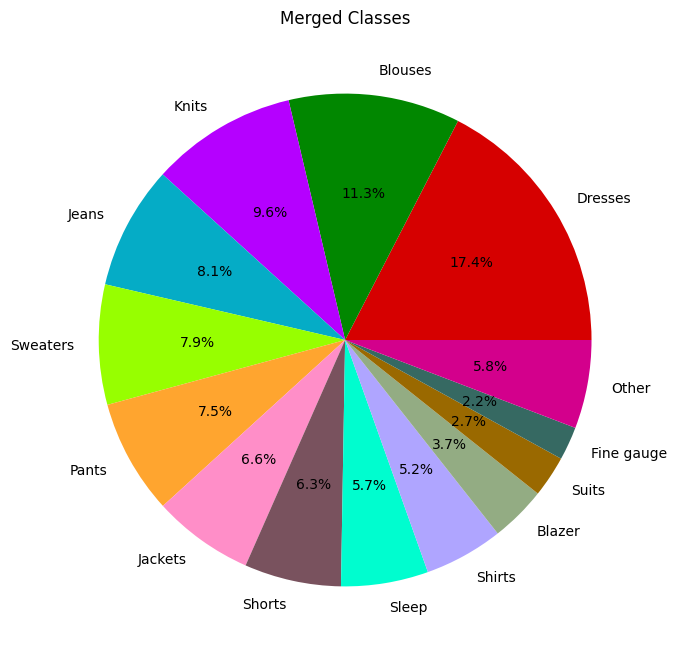

In [6]:
pie_plot(df.Cloth_class.value_counts(), 0.02)
plt.show()

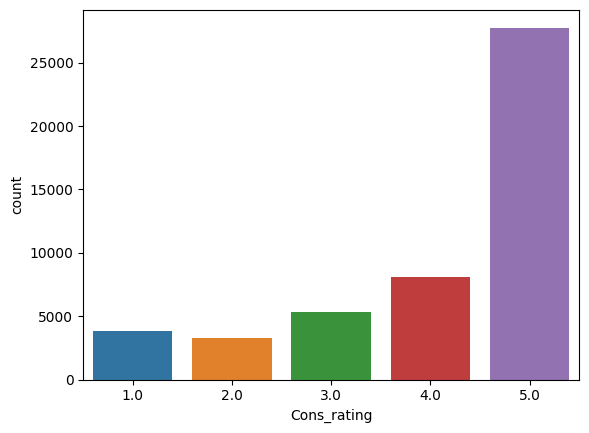

In [7]:
sns.countplot(data=df, x='Cons_rating')
plt.show()


The most frequently mentioned items are dresses and blouses.
The majority of the ratings are equal to five

****To better understand the main content of the Reviews, we use Wordcloud, to better understand the main topic of the Reviews, and a barplot relative to the trigrams, to better understand the main meaning of the reviews.****

Before doing it, we perform stemming to reduce words to their roots

In [8]:
stemmer = nltk.stem.SnowballStemmer('english')
df['stemmed'] = df['Review'].str.split().apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
def list_to_sentence(word_list):
    return ' '.join(word_list)

df['sentence'] = df['stemmed'].apply(list_to_sentence)

The Latent Dirichlet Analysis allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar

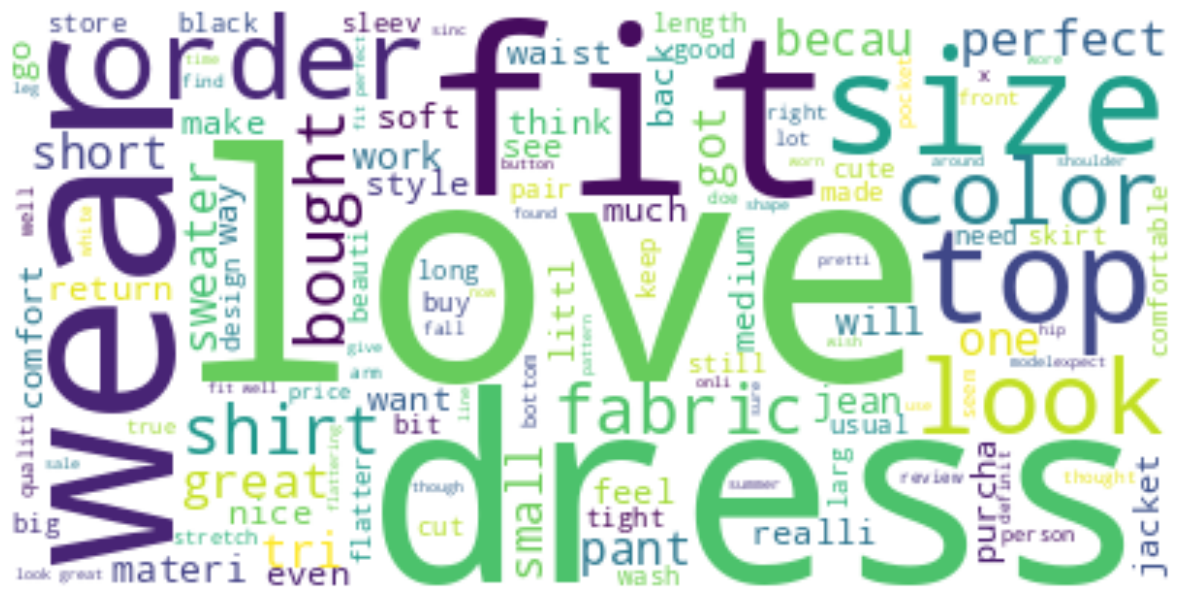

In [9]:
text = " ".join(i for i in df.sentence)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Main words are love, dress, fit, size and wear. 

In [10]:
vectorizer = CountVectorizer(max_features=300, stop_words='english',ngram_range=(3,3))
X_nlp3 = vectorizer.fit_transform(df['sentence'])
count_array = X_nlp3.toarray()
df1 = pd.DataFrame(data=count_array, columns=vectorizer.get_feature_names_out())



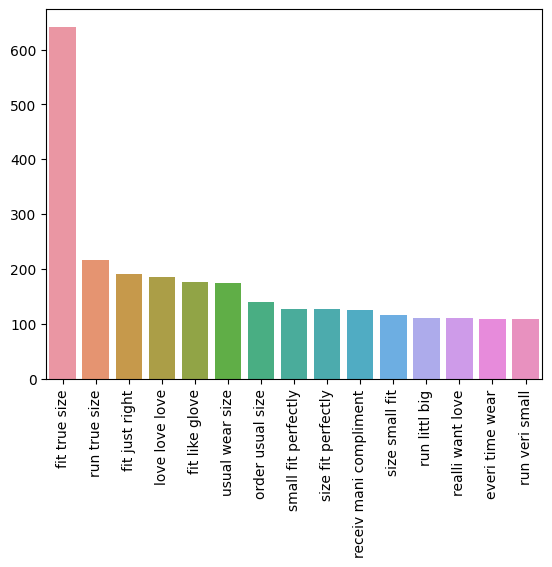

In [11]:
a=df1.sum().sort_values(ascending=False)[0:15]
g=sns.barplot(y=a, x=a.index)
plt.xticks(rotation=90)
plt.show()

Most of the main trigrams pertain to positive reviews.

# Topic Modeling 

The Latent Dirichlet Analysis allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar


In [12]:
vectorizer = CountVectorizer(max_features=300, stop_words='english',ngram_range=(1,1))
X_nlp1 = vectorizer.fit_transform(df['Review'])


In [13]:
lda = LatentDirichletAllocation(n_components=3, random_state=0)
topics = lda.fit_transform(X_nlp1)

# Get the top words for each topic
feature_names = vectorizer.get_feature_names_out()
top_words = []

for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-10-1:-1]
    top_words.append([feature_names[i] for i in top_words_idx])

# Print out the top words for each topic
for i, words in enumerate(top_words):
    print(f"Topic {i+1}:")
    print(", ".join(words))

Topic 1:
dress, like, fabric, just, love, really, color, sweater, look, looks
Topic 2:
size, small, fit, ordered, large, wear, dress, medium, waist, little
Topic 3:
great, fit, comfortable, love, perfect, jeans, good, bought, quality, pants


In [14]:
df1['topic']=[np.argmax(prob)+1 for prob in topics]
df1.topic.value_counts()

topic
3    19088
1    17108
2    12086
Name: count, dtype: int64

We obtained three topics, but there aren't clear differences between them. The second topic consists of reviews about fit (including sizes like small, medium, and large, as well as verbs like "fit" and "wear"). The third topic pertains to positive reviews for jeans and pants, while the first topic is the same for dresses and sweaters.

# TF IDF Analysis

In this section, I aim to identify the words characterizing the best and worst reviews. To achieve this, I employ TF-IDF, a technique used to identify words that characterize each document.

In [15]:
from textblob import TextBlob

# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

In [16]:
vectorizer = TfidfVectorizer( sublinear_tf=True, max_df=0.6, min_df=100, stop_words='english',tokenizer=textblob_tokenizer)
X = vectorizer.fit_transform(df.Review)
count_array = X.toarray()
df_idf = pd.DataFrame(data=count_array, columns=vectorizer.get_feature_names_out())
df.reset_index(inplace=True, drop=True)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

Computed TF-IDF, I select the worst and the best reviews and, for the first 30 reviews, I show their words, and their TF-IDF

In [17]:
df1 = df_idf.loc[df.Cons_rating==1]
df1=df1.loc[df1.max(axis=1)>=0.6]
df11=df1.iloc[0:30,:]

tfidf_df1 = df11.stack().reset_index()
tfidf_df1 = tfidf_df1.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
top_tfidf1 = tfidf_df1.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf1.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf1.shape[0])*0.000001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)


# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + text).properties(width = 600)

alt.LayerChart(...)

In  the first worst reviews, words such as 'cheap', 'poor,' 'disappoint,' and 'shrunk' stand out.

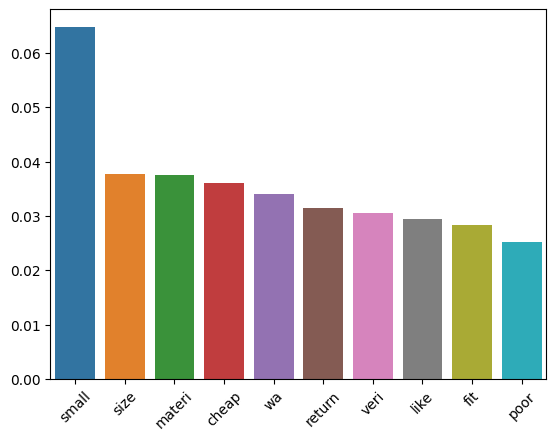

In [18]:
a=df1.mean().sort_values(ascending=False)[0:10]
sns.barplot(y=a, x=a.index)
plt.xticks(rotation=45)
plt.show()

Some of the most important words in bad reviews are small, cheap, return and poor

In [19]:
df5 = df_idf.loc[df.Cons_rating==5]
df5=df5.loc[df5.max(axis=1)>=0.6]
df51=df5.iloc[0:30,:]

tfidf_df5 = df51.stack().reset_index()
tfidf_df5 = tfidf_df5.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
top_tfidf5 = tfidf_df5.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)


# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf5.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf5.shape[0])*0.000001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)


# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + text).properties(width = 600)

alt.LayerChart(...)

There stands out words like 'style', 'beauti'.

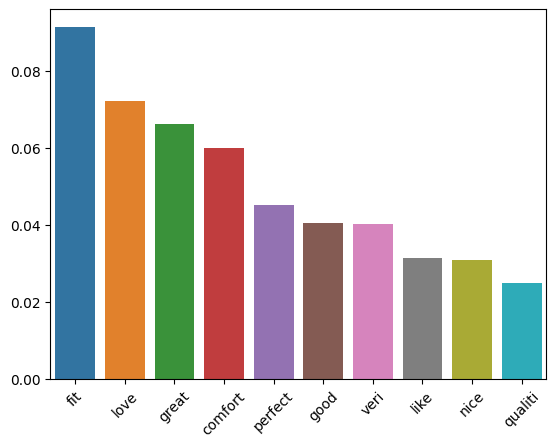

In [20]:
a=df5.mean().sort_values(ascending=False)[0:10]
sns.barplot(y=a, x=a.index)
plt.xticks(rotation=45)

plt.show()


Some of the most important words in top reviews are fit, love, great, comfort, perfect and good.

****We have identified the words characterizing good and bad reviews. The next step is constructing a model to predict review ratings. Such a model can be useful for two reasons:****

- ****It enables us to determine the most plausible rating for reviews without any rating.****

- ****It allows us to study the most important factors that contribute to a rating being positive or negative.****

# Rating Prediction

To simplify the problem, we want to predict rating divided into two levels: good if the rating is 4 or 5, bad if it is smaller than 4.

In [21]:
df_final=df_idf.copy()
df_final['Cons_rating']=df.Cons_rating
df_final['Rating']='High'
df_final.loc[df_final.Cons_rating<=3,'Rating']='Low'

We split the data in train and test set. Before fitting the model, we balance the train set.

In [22]:
X=df_final.drop(['Cons_rating', 'Rating'], axis=1)
y=pd.get_dummies(df_final.Rating).Low
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
rus = RandomUnderSampler(random_state=0)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

In [23]:
param_grid_ridge = {
'tol': [0.001,0.002,0.005,0.01]
}

# Create the RandomForestRegressor
ridge = RidgeClassifier(random_state=42)

# Instantiate GridSearchCV
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, 
                           cv=5, n_jobs=-1, verbose=0)

# Perform Grid Search to find the best parameters
grid_search_ridge.fit(X_train_bal, y_train_bal)

# Best parameters and best estimator
best_params = grid_search_ridge.best_params_
ridge_model = grid_search_ridge.best_estimator_

ridge_model.fit(X_train_bal, y_train_bal)
pred = ridge_model.predict(X_test)

In [24]:
cmtx = pd.DataFrame(
    confusion_matrix(y_test, pred), 
    index=['true : High', 'true : Low'], 
    columns=['pred : High', 'pred : Low']
)
print(cmtx)
print('')
print('Accuracy:', accuracy_score(y_test,pred))

             pred : High  pred : Low
true : High         7329        1639
true : Low           535        2568

Accuracy: 0.8198989313230055


The model has good predictions: its accuracy is equal to 82 %


In [25]:
a=sorted_indices = np.argsort(np.abs(ridge_model.coef_))
sorted_array1 = ridge_model.feature_names_in_[sorted_indices]
sorted_array1[0][-10:]

array(['exactli', 'howev', 'comfort', 'glad', 'keeper', 'return', 'great',
       'compliment', 'love', 'perfect'], dtype=object)

The highest coefficients are associated with words like 'perfect,' 'love,' 'compliment,' 'great,' 'return,' and 'glad.'

This means that these words allow us to distinguish between good and bad reviews.